In [2]:
from pathlib import Path


DATA_dir = Path('../data/')
IMAGES_DIR = Path(DATA_dir / 'images/')

In [3]:
import pandas as pd
import math

trainset = pd.read_json(DATA_dir / "trainset.json")
testset = pd.read_json(DATA_dir / "testset.json")

target = 'HEAD'
trainset = trainset[trainset['image_organ'] == target]
testset = testset[testset['image_organ'] == target]

In [4]:
trainset

qid       image_name image_organ                  answer answer_type  \
0        1  synpic54610.jpg        HEAD                     Yes      CLOSED   
8        9  synpic39460.jpg        HEAD      left temporal lobe        OPEN   
11      15  synpic54610.jpg        HEAD             vasculature        OPEN   
13      17  synpic54610.jpg        HEAD  MRI Diffusion Weighted        OPEN   
14      18  synpic54610.jpg        HEAD               the brain        OPEN   
...    ...              ...         ...                     ...         ...   
3049  3501  synpic53816.jpg        HEAD                      No      CLOSED   
3056  3508  synpic56841.jpg        HEAD                   FLAIR      CLOSED   
3057  3509  synpic56841.jpg        HEAD                   FLAIR      CLOSED   
3058  3510  synpic56841.jpg        HEAD                   FLAIR      CLOSED   
3059  3511  synpic56841.jpg        HEAD                   FLAIR      CLOSED   

     question_type                                           question  \
0             PRES                Are regions of the brain infarcted?   
8              POS                          Where is the abnormality?   
11             POS              Where is the pathology in this image?   
13        MODALITY                      What type of imaging is this?   
14           ORGAN                     What organ system is pictured?   
...            ...                                                ...   
3049          PRES                            Is there midline shift?   
3056      MODALITY  Is this a T1 weighted, T2 weighted, or FLAIR i...   
3057      MODALITY        What is/are the image weighting of the MRI?   
3058      MODALITY           Is this image modality T1, T2, or FLAIR?   
3059      MODALITY        What is/are the image weighting of the MRI?   

     phrase_type  
0       freeform  
8       freeform  
11      freeform  
13      freeform  
14      freeform  
...          ...  
3049       frame  
3056    freeform  
3057       frame  
3058        para  
3059       frame  

[977 rows x 8 columns]

In [5]:
testset

qid       image_name image_organ                  answer answer_type  \
2      14  synpic54610.jpg        HEAD                     yes      CLOSED   
4      22  synpic54610.jpg        HEAD                     yes      CLOSED   
56    427  synpic57368.jpg        HEAD  Ring-enhancing lesions        OPEN   
57    429  synpic57368.jpg        HEAD                     Yes      CLOSED   
58    431  synpic56799.jpg        HEAD     right temporal lobe        OPEN   
..    ...              ...         ...                     ...         ...   
437  3026  synpic31116.jpg        HEAD                     MRI      CLOSED   
438  3027  synpic31116.jpg        HEAD                     MRI      CLOSED   
439  3030  synpic42951.jpg        HEAD                   axial        OPEN   
440  3055  synpic31928.jpg        HEAD                      no      CLOSED   
441  3057  synpic31928.jpg        HEAD                      no      CLOSED   

    question_type                                       question phrase_type  
2           PLANE                        Is this an axial plane?    freeform  
4             ABN     Is there vascular pathology in this image?    freeform  
56         ATTRIB       How would you describe the abnormalities    freeform  
57   ATTRIB, PRES                Are the lesions ring-enhancing?        para  
58            POS            What lobe is the lesion located in?        para  
..            ...                                            ...         ...  
437      MODALITY                        Is this a CT or an MRI?    freeform  
438      MODALITY  Was a CT or MRI used to take the above image?        para  
439         PLANE             This image is taken in what plane?    freeform  
440          SIZE           Are the ventricles an abnormal size?    freeform  
441          SIZE        Is the size of the ventricles abnormal?        para  

[119 rows x 8 columns]

In [158]:
import re
import cv2
import matplotlib.pyplot as plt


def load_image(idx, source=trainset):
    item = source.iloc[idx]
    img = cv2.imread(str(IMAGES_DIR / item['image_name']), cv2.CV_8UC1)
    return img


def display_image(start, nrow=3, ncol=3, source=trainset):
    if not nrow or not ncol:
        raise ValueError('nrow and ncol must be positive integers')

    for i in range(nrow * ncol):
        item = source.iloc[start + i]
        img = cv2.imread(str(IMAGES_DIR / item['image_name']))
        id = ''.join(re.findall(r'\d+', item['image_name']))
        title = id + '\n' + item['question'] + '\n' + item['answer']
        scale = abs(nrow - 1) * 0.3, abs(ncol - 1) * 0.8

        plt.subplot(nrow, ncol, i+1)
        plt.subplots_adjust(hspace=scale[0], wspace=scale[1])
        plt.imshow(img)
        plt.title(title,fontsize=8)
        plt.xticks([])
        plt.yticks([])

    plt.show()

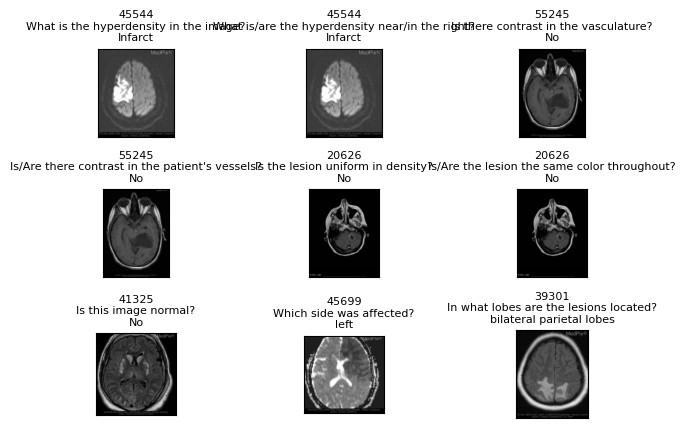

977
103


In [159]:
display_image(700)
print(len(trainset['image_name']))
print(len(trainset['image_name'].unique()))

### Image Preprocessing

In [189]:
import numpy as np
import scipy.stats as stats


def adjust_tilt(img):
    contours, h = cv2.findContours(img, cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)

    # cv2.drawContours(img, contours, -1, (255, 0, 0), 3)

    # find the biggest contour (c) by the area
    c = max(contours, key=cv2.contourArea)

    (x, y), (a, b), angle = cv2.fitEllipse(c)

    cv2.ellipse(img, ((x, y), (a, b), angle), color=(0, 255, 0), thickness=2)

    rmajor = max(a, b) / 2

    if angle > 90:
        angle -= 90
    else:
        angle += 90

    xtop = x + math.cos(math.radians(angle)) * rmajor
    ytop = y + math.sin(math.radians(angle)) * rmajor
    xbot = x + math.cos(math.radians(angle + 180)) * rmajor
    ybot = y + math.sin(math.radians(angle + 180)) * rmajor
    cv2.line(img, (int(xtop), int(ytop)), (int(xbot), int(ybot)), (0, 255, 0),
             3)

    plt.imshow(img)
    plt.show()

    M = cv2.getRotationMatrix2D((x, y), angle - 90, 1)  # transformation matrix
    img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), cv2.INTER_CUBIC)

    plt.imshow(img)
    plt.show()

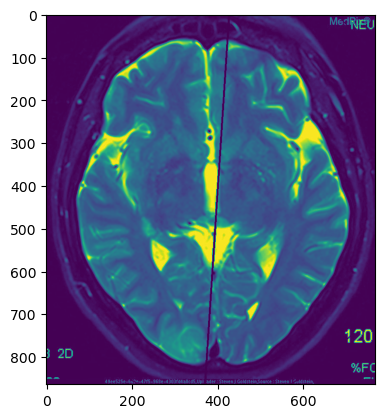

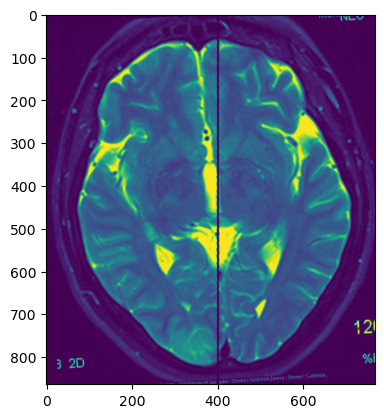

In [190]:
import random

n = random.randint(0, len(trainset))
item = trainset.iloc[n]
img = cv2.imread(str(IMAGES_DIR / item['image_name']))
adjust_tilt(img)

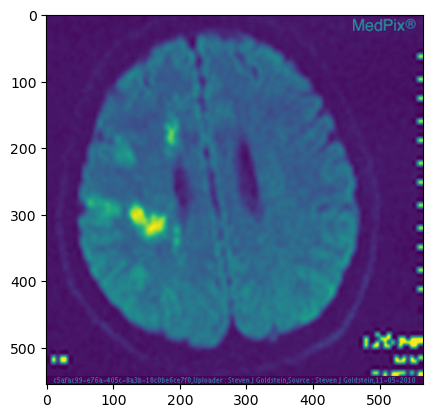

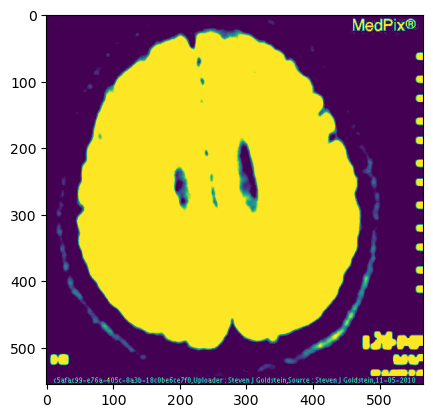

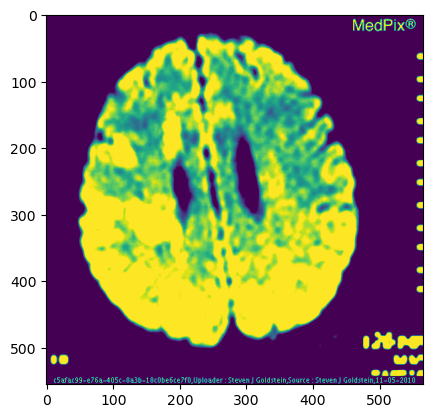

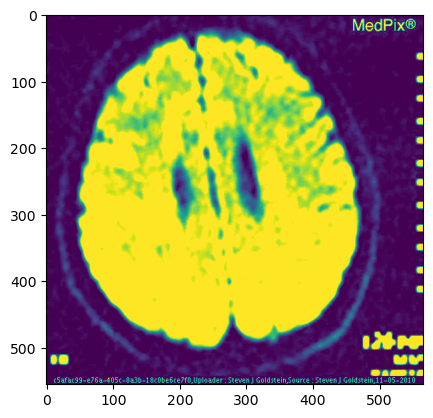

In [153]:
import random

def hu_transform(img, ww, wl, dst_range=(0, 1)):
    src_min = wl - ww / 2
    src_max = wl + ww / 2
    outputs = (img - src_min) / ww * (dst_range[1] - dst_range[0]) + dst_range[0]
    outputs[img >= src_max] = 1
    outputs[img <= src_min] = 0

    outputs *= 255

    return outputs

n = random.randint(0, len(trainset))
n = 0

img = load_image(n)
plt.imshow(img)
plt.show()

output = hu_transform(img, 24, 34)
plt.imshow(output)
plt.show()

output = hu_transform(img, 48, 68)
plt.imshow(output)
plt.show()

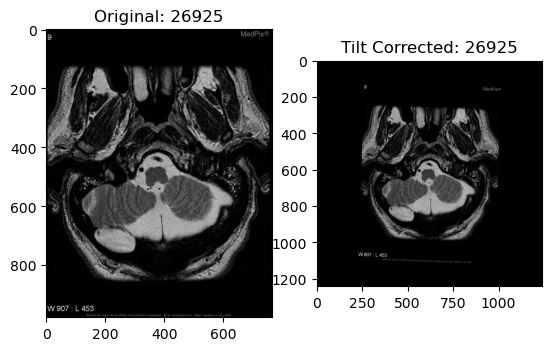

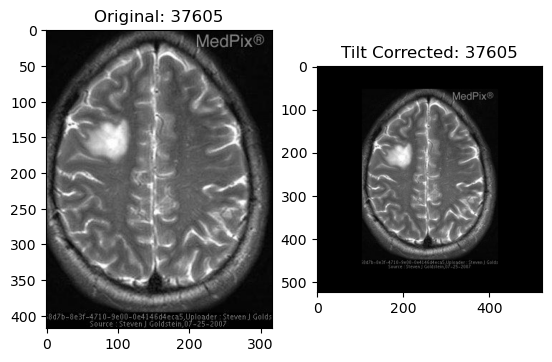

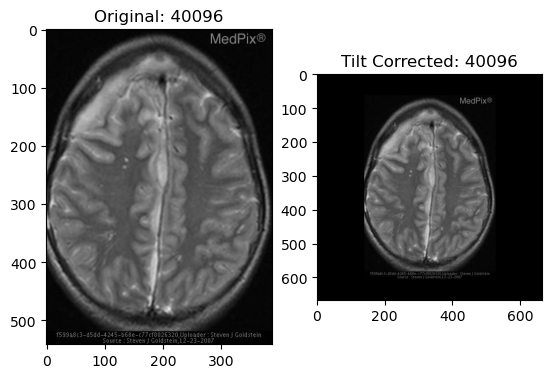

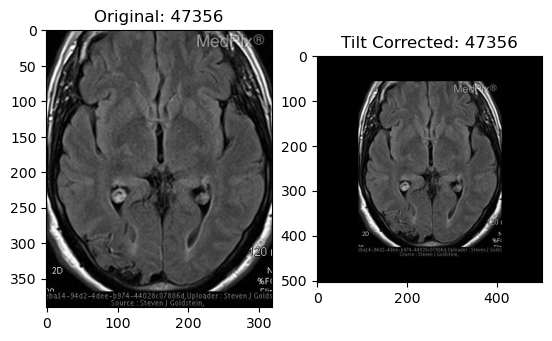

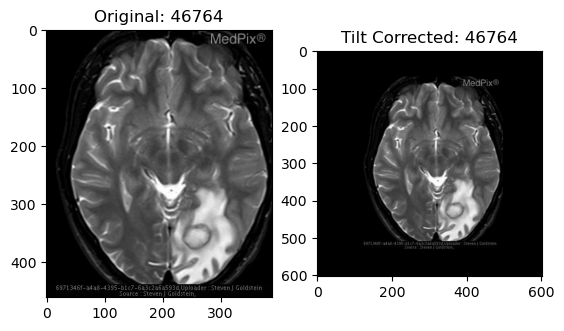

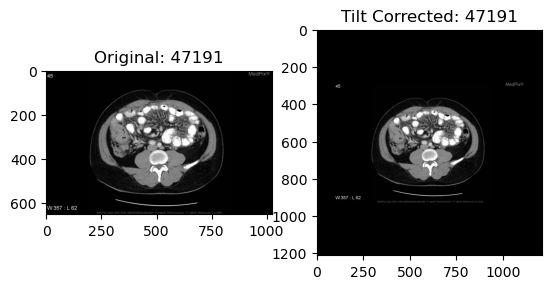

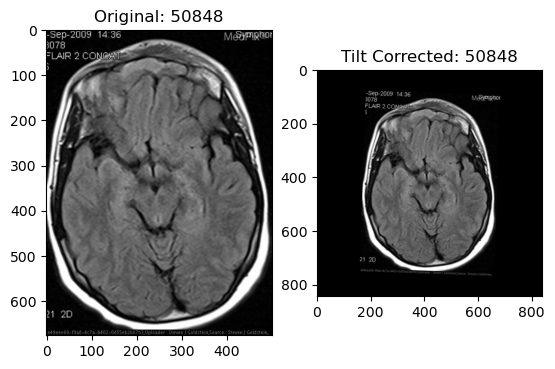

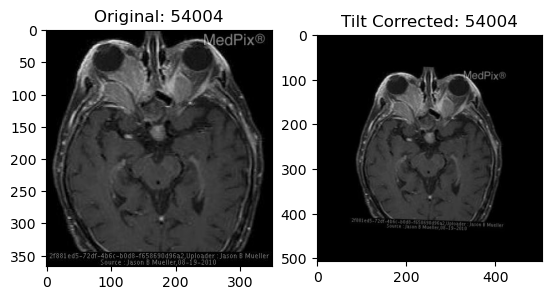

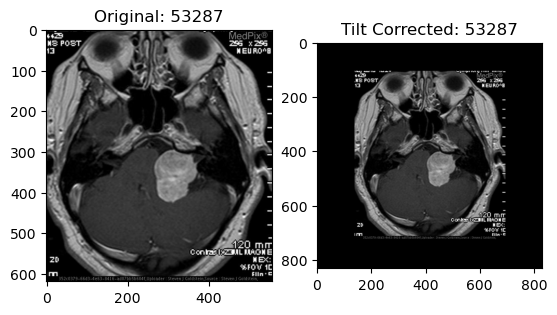

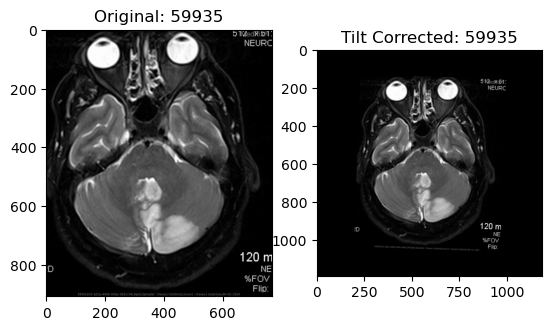

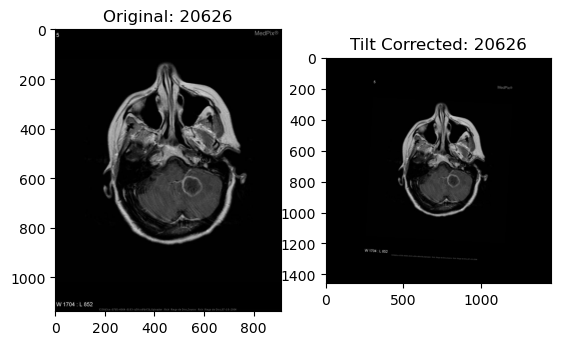

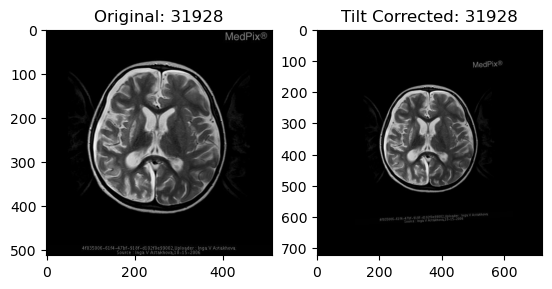

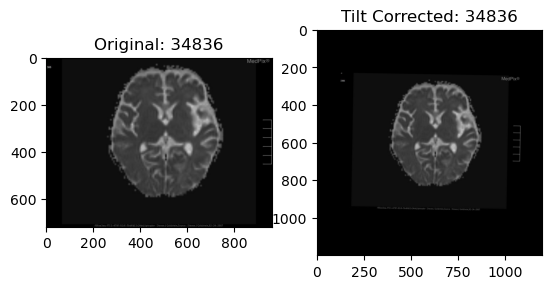

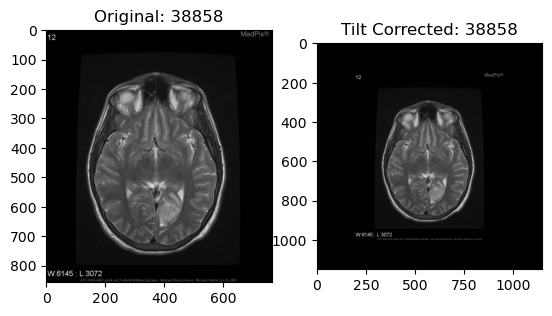

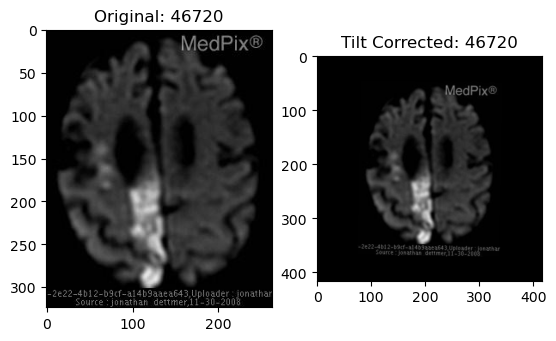

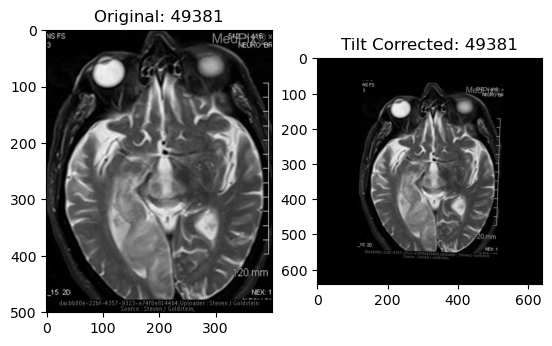

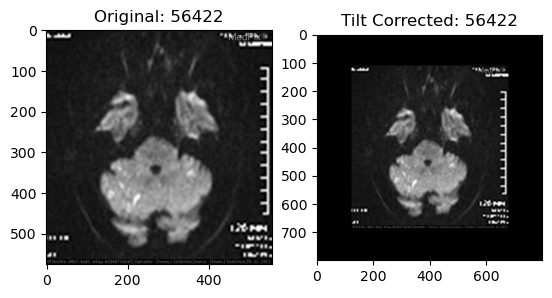

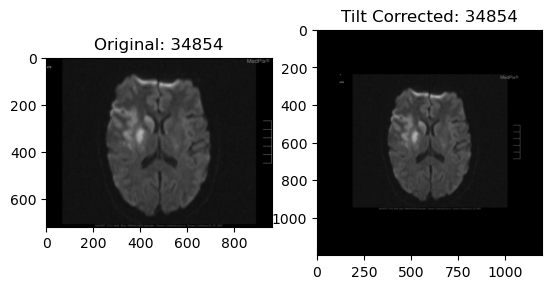

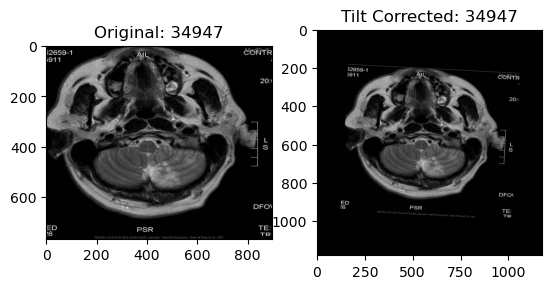

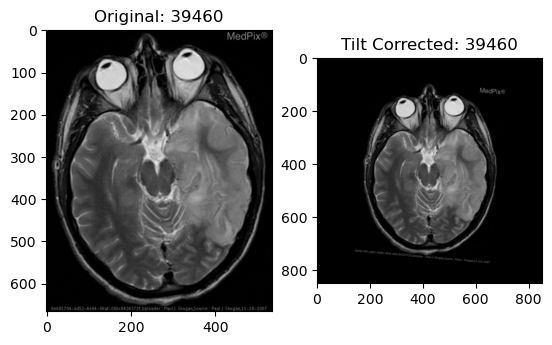

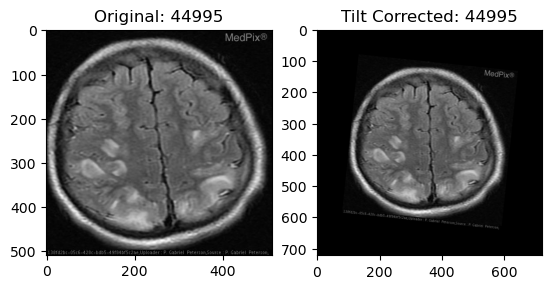

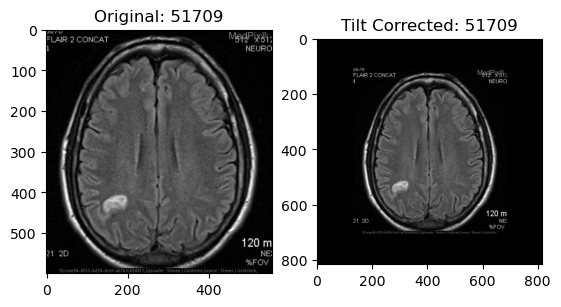

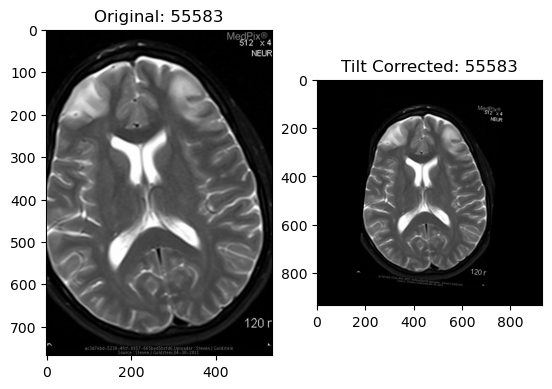

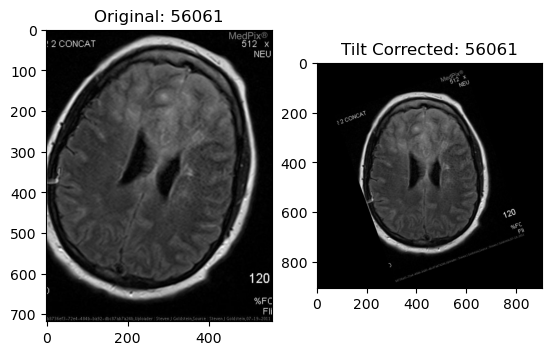

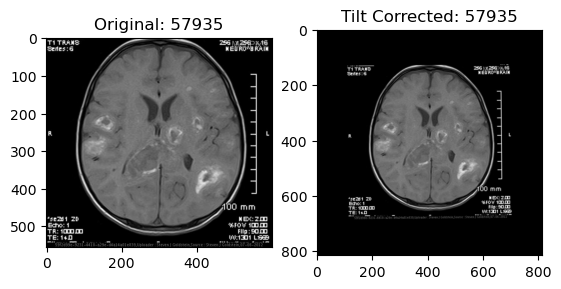

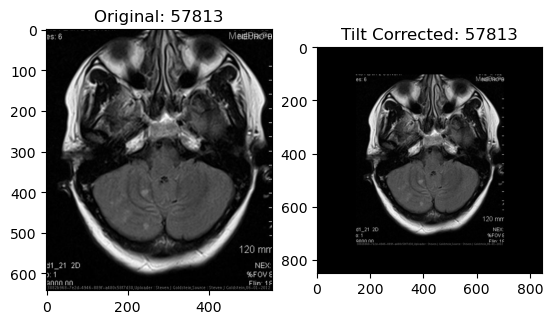

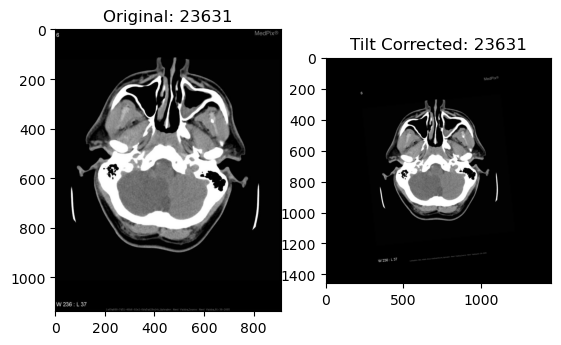

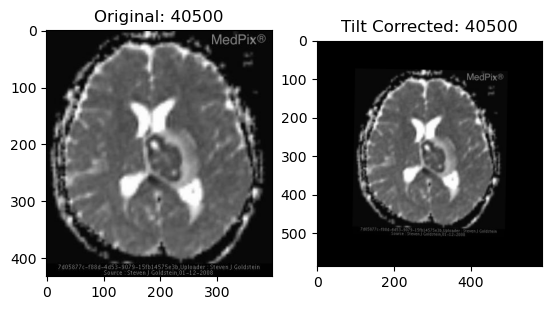

In [6]:


from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt


DIC_CORRECTED = {
    # HEAD MRI
    '26925': -2, '37605': 0, '40096': 0, '47356': 0, '46764': 0 , '47191': 0, '50848': -2 , '54004': -2, '53287': 0, '59935': -2,
    '20626': -3, '31928': 3, '34836': -1, '38858': 0, '46720': -1, '49381': -2, '56422': 0,
    '34854': 0, '34947': -3, '39460': -5, '44995': -6, '51709': 0, '55583': -6, '56061': 20, '57935': 0.5,
    # HEAD CT
    '57813': 0,
    '23631': 6, '40500': -1
    }

def pad_and_tilt_image(image_path, angle_degrees):
    # Load the image
    image = cv2.imread(image_path)

    # Calculate the new dimensions for the padded image
    height, width = image.shape[:2]
    diagonal = np.sqrt(height**2 + width**2)
    pad_height = int(diagonal - height) // 2
    pad_width = int(diagonal - width) // 2

    # Pad the image
    padded_image = cv2.copyMakeBorder(image, pad_height, pad_height, pad_width, pad_width, cv2.BORDER_CONSTANT)

    # Calculate the center of the image
    center = (padded_image.shape[1] // 2, padded_image.shape[0] // 2)

    # Perform the rotation
    rotation_matrix = cv2.getRotationMatrix2D(center, angle_degrees, 1.0)
    tilted_image = cv2.warpAffine(padded_image, rotation_matrix, (padded_image.shape[1], padded_image.shape[0]))

    return tilted_image

output_dir = '../tilt_corrected'
Path(output_dir).mkdir(parents=True, exist_ok=True)

for img_name in DIC_CORRECTED:
    image_path = str(IMAGES_DIR / f'synpic{img_name}.jpg')  # Replace with the path to your image

    try:
        tilted_image = pad_and_tilt_image(image_path, DIC_CORRECTED[img_name])  # Tilt counterclockwise by 5 degrees
    except AttributeError:
        print(f'Error processing {img_name}')
        continue

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.imread(image_path))
    plt.title(f'Original: {img_name}')

    plt.subplot(1, 2, 2)
    plt.imshow(tilted_image)
    plt.title(f'Tilt Corrected: {img_name}')

    plt.show()

    cv2.imwrite(f'{output_dir}/synpic{img_name}.jpg', tilted_image)